In [1]:
import re
import csv
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from datasets import load_dataset

SEED = 1337
random.seed(SEED)

INFO 03-15 22:35:10 __init__.py:190] Automatically detected platform cuda.


In [2]:
dataset = load_dataset("euclaise/writingprompts")
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'story'],
        num_rows: 272600
    })
    test: Dataset({
        features: ['prompt', 'story'],
        num_rows: 15138
    })
    validation: Dataset({
        features: ['prompt', 'story'],
        num_rows: 15620
    })
})

In [3]:
df = pd.concat([dataset['train'].to_pandas(), dataset['validation'].to_pandas(), dataset['test'].to_pandas()])
df.head()

,prompt,story
0,[ WP ] You 've finally managed to discover the...,"So many times have I walked on ruins, the rema..."
1,"[ WP ] The moon is actually a giant egg , and ...","-Week 18 aboard the Depth Reaver, Circa 2023- ..."
2,[ WP ] You find a rip in time walking through ...,"I was feckin' sloshed, mate. First time I ever..."
3,[ WP ] For years in your youth the same imagin...,"“ No, no no no... ” She backed up and turned t..."
4,"[ WP ] You glance at your watch 10:34 am , rou...",There's a magical moment between wakefulness a...


In [4]:
df.isna().sum()

prompt    0
story     0
dtype: int64

In [5]:
prefixes = [prompt[:6] for prompt in df['prompt'].values]

In [6]:
unique, counts = np.unique(prefixes, return_counts=True)
sorted_indices = np.argsort(-counts)
unique, counts = unique[sorted_indices], counts[sorted_indices]
unique

array(['[ WP ]', '[ IP ]', '[ CW ]', '[ EU ]', '[ OT ]', '[ TT ]',
       '[ FF ]', '[ wp ]', '[ PI ]', '[ RF ]', '( WP )', '[ MP ]',
       '[ Wp ]', '[ CC ]', 'Write ', '[ PM ]', "You 'r", 'You ar',
       'Writin', '[ RE ]', '[ CS ]', '[ CONT', '( EU )', '[ cw ]',
       '[ HP ]', '[ WS ]', 'A man ', 'In 100', '{ WP }', 'A dead',
       '[ WP/E', '[ WR ]', '( CW )', 'The la', 'WP : A', 'All in',
       'You wa', "You 'v", 'The ye', 'Daily ', '[ WP }', 'After ',
       '`` Thi', 'You li', 'Make a', '[ Modp', 'Earth ', 'You ha',
       'Magic ', '[ ff ]', 'Make m', '[ Writ', 'Pack a', 'At you',
       '[ Eu ]', 'Last w', 'Last s', 'Descri', '[ WP/M', 'Gettin',
       '[ WP ,', '[ WT ]', '[ NANO', 'The Fo', 'There ', '`` You',
       'A worl', 'DAILY ', "I 've ", '[ WP/C', "I 'm a", 'As you',
       'Random', 'Prompt', 'Why is', 'Humans', 'A depr', '[ NSFW',
       'You he', 'Create', 'Pictur', 'Shortl', 'In the', '[ [ WP',
       'In an ', '( wp )', 'Two me', 'Give m', '`` A l', 'Meet

In [7]:
# First 14 prefiex account for 98% of the prefiexes
sum(counts[:14]) / sum(counts)

np.float64(0.981180651243745)

In [8]:
prefixes = unique[:14]
pattern = r'^(?:' + '|'.join(re.escape(prefix) for prefix in prefixes) + r')\s*'

In [9]:
def remove_prefix(text):
    return re.sub(pattern, '', text)

In [10]:
df["prompt"] = df["prompt"].apply(remove_prefix)
df.head()

,prompt,story
0,You 've finally managed to discover the secret...,"So many times have I walked on ruins, the rema..."
1,"The moon is actually a giant egg , and it has ...","-Week 18 aboard the Depth Reaver, Circa 2023- ..."
2,You find a rip in time walking through the all...,"I was feckin' sloshed, mate. First time I ever..."
3,For years in your youth the same imaginary cha...,"“ No, no no no... ” She backed up and turned t..."
4,"You glance at your watch 10:34 am , roughly 10...",There's a magical moment between wakefulness a...


In [11]:
df["prompt_length"] = df["prompt"].str.len()
df["story_length"] = df["story"].str.len()

In [12]:
df = df[df["prompt_length"] >= 10]

In [13]:
df.duplicated(subset="story").sum()

np.int64(199)

In [14]:
df.drop_duplicates(subset=["story"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [15]:
len(df)

301886

In [16]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [17]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful assistant for writing stories based on provided prompt. Based on provided prompt generate a story. MAKE SURE TO REPLAY ONLY WITH THE STORY."},
                {"role": "user", "content": "Prompt: \n {prompt}"},
                {"role": "assistant", "content": "Story: \n"}]

In [18]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(prompt=prompt)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for prompt in df["prompt"].values
]

In [19]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [20]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

2359it [01:18, 30.06it/s]                          


In [ ]:
too_large = [i for i, l in enumerate(lens) if l > 16_384]
too_large

[]

In [22]:
df.drop(["prompt", "prompt_length", "story_length"], axis=1, inplace=True)
df.to_csv("../../data/data_human/writingprompts.csv", index=False)

In [23]:
from nltk.tokenize import word_tokenize, sent_tokenize
df['word_count'] = df['story'].apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['story'].apply(lambda x: len(sent_tokenize(x)))

In [24]:
import numpy as np
import matplotlib.ticker as ticker

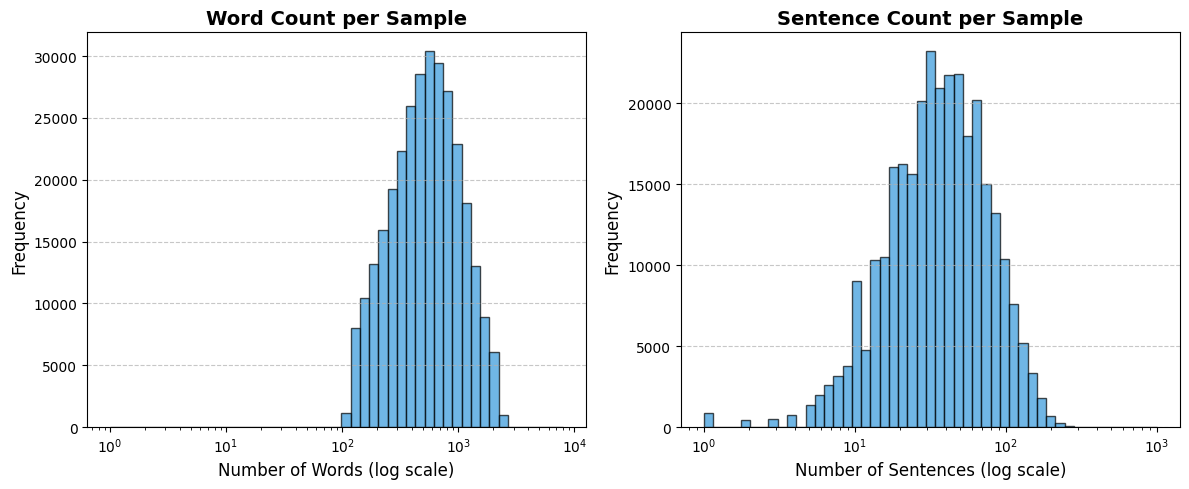

In [25]:
import matplotlib.pyplot as plt
word_bins = np.logspace(np.log10(1), np.log10(df['word_count'].max()), 50)
sentence_bins = np.logspace(np.log10(1), np.log10(df['sentence_count'].max()), 50)

# Plot histograms using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Word count histogram
axes[0].hist(df['word_count'], bins=word_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xscale('log')  # Logarithmic scale for x-axis
axes[0].set_title('Word Count per Sample', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words (log scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].tick_params(axis='both', which='minor', labelsize=8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sentence count histogram
axes[1].hist(df['sentence_count'], bins=sentence_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].set_title('Sentence Count per Sample', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Sentences (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].tick_params(axis='both', which='minor', labelsize=8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [35]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=30_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=30_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=30_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=30_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=30_000, seed=SEED),  # Highly Creative
]

In [36]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/writingprompts/writingprompts_"

In [37]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-15 20:35:51 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-15 20:36:03 config.py:542] This model supports multiple tasks: {'generate', 'score', 'embed', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 02-15 20:36:03 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-15 20:36:52 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-15 20:36:54 worker.py:267] Memory profiling takes 2.22 seconds
INFO 02-15 20:36:54 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-15 20:36:54 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-15 20:36:55 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-15 20:36:55 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-15 20:37:53 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:30<00:00,  1.14it/s]

INFO 02-15 20:38:24 model_runner.py:1562] Graph capturing finished in 31 secs, took 0.12 GiB
INFO 02-15 20:38:24 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 91.63 seconds



  0%|          | 0/37919 [00:00<?, ?it/s]

INFO 02-15 20:38:24 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/37919 [00:40<215:40:30, 20.48s/it]


In [38]:
df = pd.read_csv("../../data/data_ai/writingprompts/writingprompts_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...","I stared at the business card in my hands, my ...",1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",**The Lunar Egg Awakens**\n\nDeep within the h...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...","I slowly sat up, my mind reeling as I tried to...",1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",I had always been fascinated by the recurring ...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...","I slowly opened my eyes, groggily taking in my...",1.2,0.7,20
